<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

on device: cuda


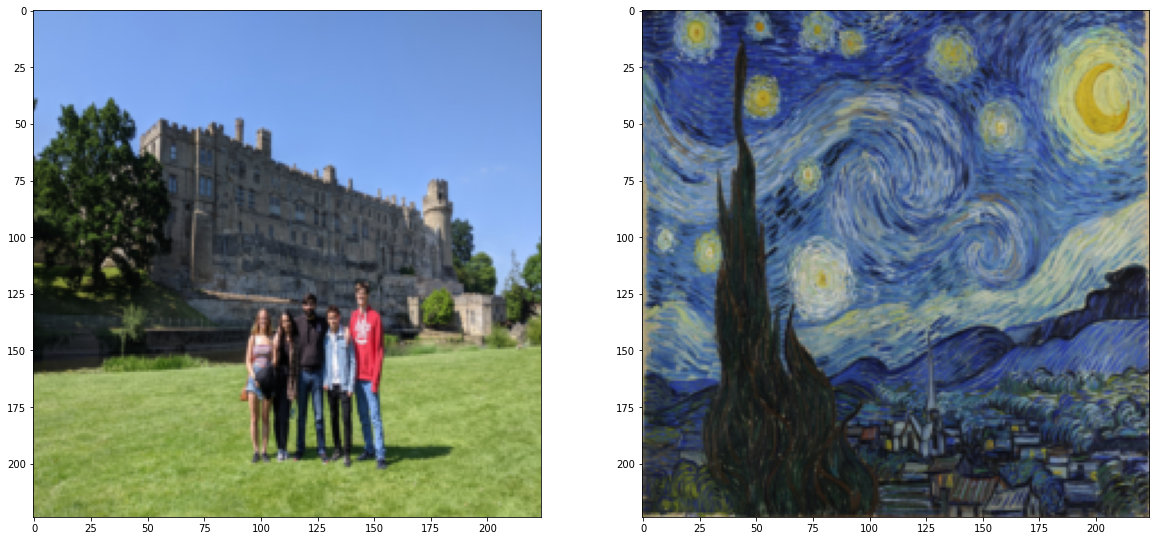

In [3]:
def load_image(image_path):
  in_transform = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
  image = Image.open(image_path)
  image = in_transform(image).unsqueeze(dim=0)
  return image.to(device)

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# content = load_image("/content/LondonEye.jpg")
# content = load_image("/content/Sherlock.jpg")
# style = load_image("/content/StarryNight.jpg")

content = load_image("/content/warwickCastle.jpg")
style = load_image("/content/StarryNight.jpg")

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [4]:
model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1).features[:29].to(device)
for param in model.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [7]:
def get_activations(model, x):
  activations = []
  output_idxs = [0, 5, 10, 19, 28]
  for layer_idx, layer in enumerate(model):
    x = layer(x)
    if layer_idx in output_idxs:
      activations.append(x)
  return activations

def calculate_gram(x):
  _, c, w, h = x.shape
  x = x.view(c, -1)
  return x @ x.T #/ (c * w * h)

content_activations = get_activations(model, content)
style_activations = get_activations(model, style)
style_grams = [calculate_gram(x) for x in style_activations]

generated = content.clone().requires_grad_(True).to(device)


Epoch: 0
loss: 16.7303 | content(alpha) contribution: 0.0000 | style(beta) contribution: 16.7303040


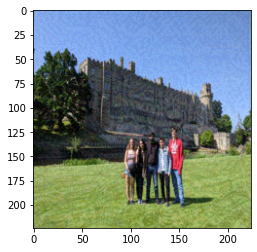


Epoch: 1000
loss: 0.7180 | content(alpha) contribution: 0.5010 | style(beta) contribution: 0.2170296


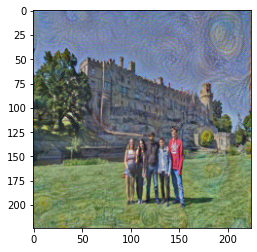


Epoch: 2000
loss: 0.6792 | content(alpha) contribution: 0.4822 | style(beta) contribution: 0.1969805


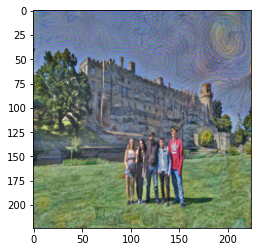


Epoch: 3000
loss: 0.8487 | content(alpha) contribution: 0.5980 | style(beta) contribution: 0.2506670


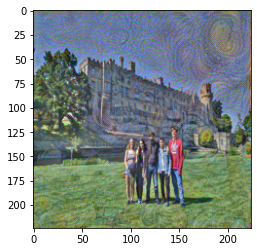


Epoch: 4000
loss: 0.8300 | content(alpha) contribution: 0.5994 | style(beta) contribution: 0.2305467


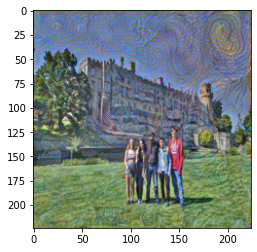


Epoch: 5000
loss: 0.7740 | content(alpha) contribution: 0.5683 | style(beta) contribution: 0.2057248


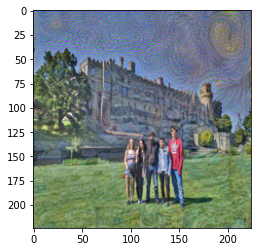


Epoch: 6000
loss: 0.8810 | content(alpha) contribution: 0.6209 | style(beta) contribution: 0.2600856


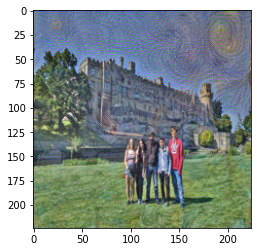


Epoch: 7000
loss: 0.8448 | content(alpha) contribution: 0.5887 | style(beta) contribution: 0.2561600


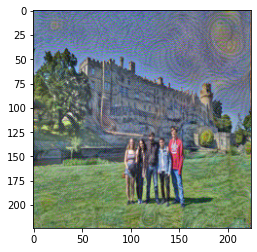


Epoch: 8000
loss: 0.8185 | content(alpha) contribution: 0.6367 | style(beta) contribution: 0.1818113


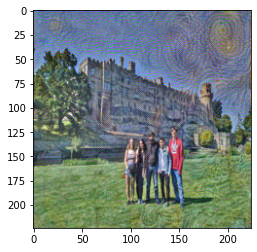


Epoch: 9000
loss: 0.9736 | content(alpha) contribution: 0.6167 | style(beta) contribution: 0.3569762


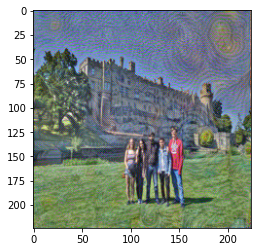


Epoch: 10000
loss: 1.0886 | content(alpha) contribution: 0.8925 | style(beta) contribution: 0.1961542


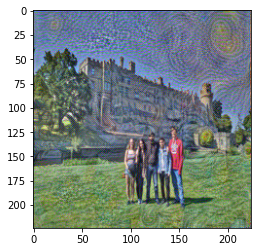


Epoch: 11000
loss: 1.0104 | content(alpha) contribution: 0.7609 | style(beta) contribution: 0.2495236


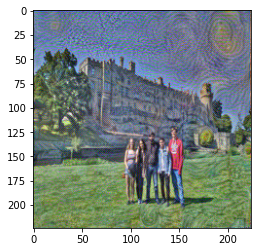

KeyboardInterrupt: ignored

In [8]:
alpha = 1
beta = 0.1
learning_rate = 1e-1
epochs = 20000
content_idx = 1
style_weights = [1, 0.75, 0.2, 0.2, 0.2]

optimizer = torch.optim.AdamW([generated], lr=learning_rate)
model.train()
for epoch in range(epochs):   
  generated_activations = get_activations(model, generated)
  content_loss = torch.mean((generated_activations[content_idx] - content_activations[content_idx])**2) # changed mean

  style_loss = 0
  generated_grams = [calculate_gram(x) for x in generated_activations]
  for i, (g, s) in enumerate(zip(generated_grams, style_grams)):
    _, c, w, h = generated_activations[i].shape
    style_loss+=style_weights[i]*torch.sum((g-s)**2) / ((c*w*h)**2)

  loss = alpha*content_loss + beta*style_loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # display intermediate images and print the loss
  if epoch % 1000 == 0:
      print(f"\nEpoch: {epoch}")
      print(f"loss: {loss.item():.4f} | content(alpha) contribution: {alpha*content_loss.item():.4f} | style(beta) contribution: {beta*style_loss.item():.7f}")
      plt.imshow(im_convert(generated))
      plt.show()

Visualizing Neurons



In [52]:
def convert_image(input_image):
    """ Display a tensor as an image. """

    image = input_image.clone().detach().cpu().numpy()
    image = image[0, :, :75, :75]
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image


Epoch: 0 | loss: -28.020416
(3, 224, 224)


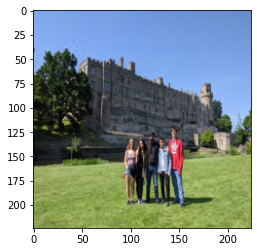

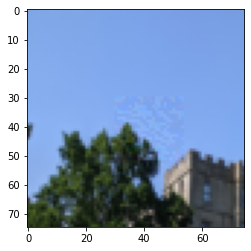


Epoch: 1000 | loss: -9830.641602
(3, 224, 224)


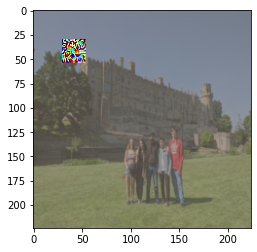

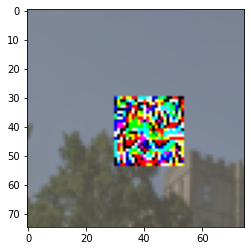


Epoch: 2000 | loss: -13425.105469
(3, 224, 224)


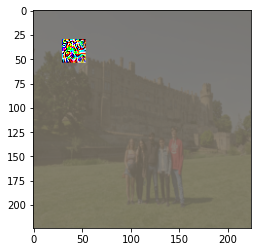

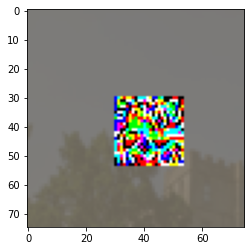


Epoch: 3000 | loss: -14721.225586
(3, 224, 224)


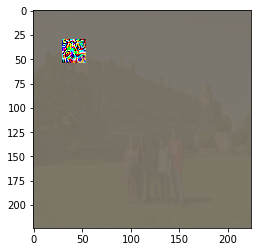

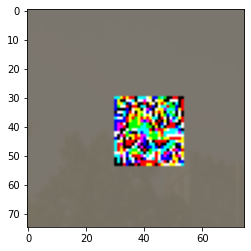


Epoch: 4000 | loss: -15257.833008
(3, 224, 224)


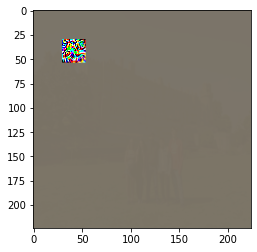

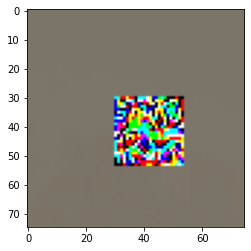


Epoch: 5000 | loss: -15459.662109
(3, 224, 224)


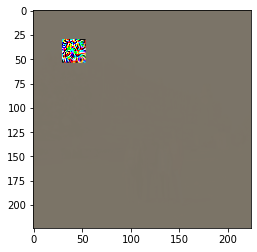

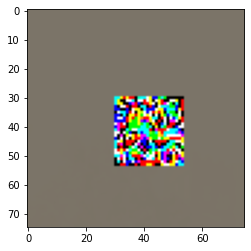


Epoch: 6000 | loss: -15543.691406
(3, 224, 224)


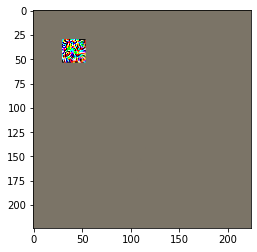

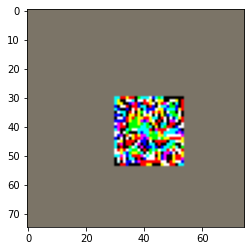


Epoch: 7000 | loss: -15549.735352
(3, 224, 224)


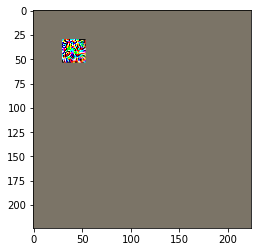

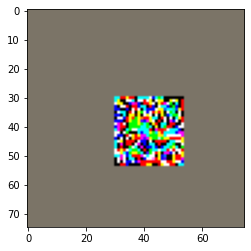


Epoch: 8000 | loss: -15562.503906
(3, 224, 224)


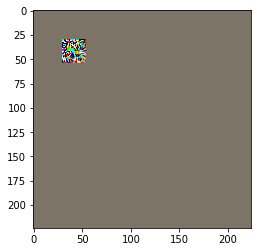

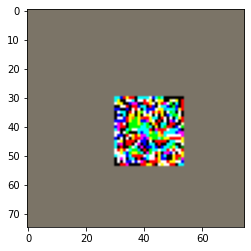


Epoch: 9000 | loss: -15607.372070
(3, 224, 224)


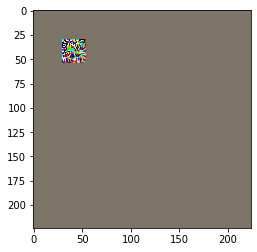

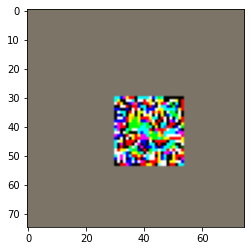


Epoch: 10000 | loss: -15672.669922
(3, 224, 224)


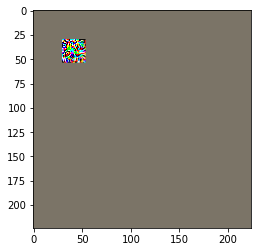

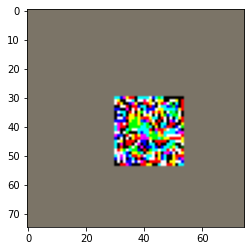


Epoch: 11000 | loss: -15670.813477
(3, 224, 224)


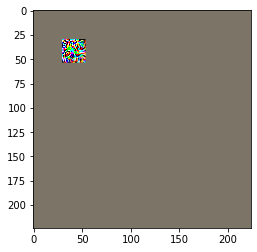

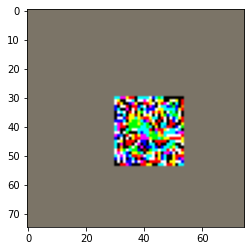


Epoch: 12000 | loss: -15657.543945
(3, 224, 224)


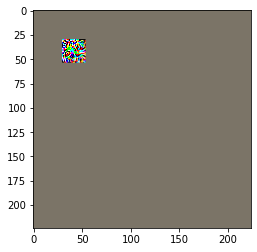

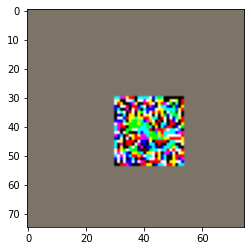


Epoch: 13000 | loss: -15643.320312
(3, 224, 224)


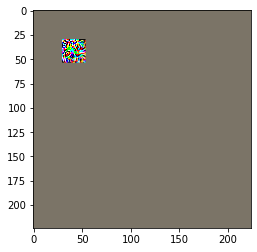

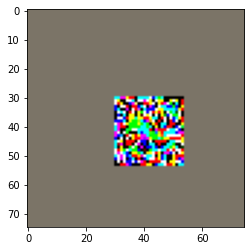


Epoch: 14000 | loss: -15635.612305
(3, 224, 224)


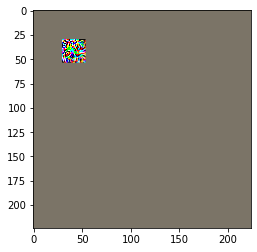

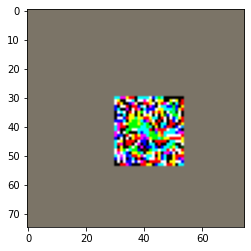


Epoch: 15000 | loss: -15643.077148
(3, 224, 224)


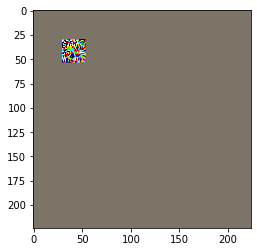

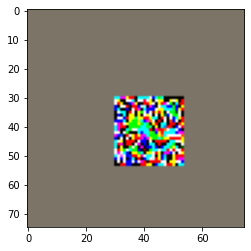


Epoch: 16000 | loss: -15646.270508
(3, 224, 224)


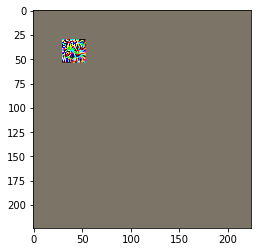

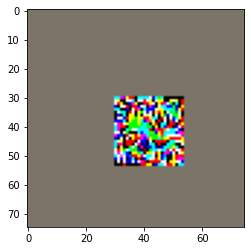


Epoch: 17000 | loss: -15646.297852
(3, 224, 224)


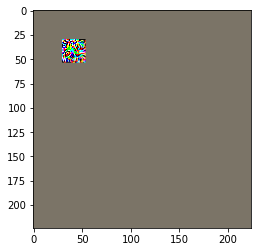

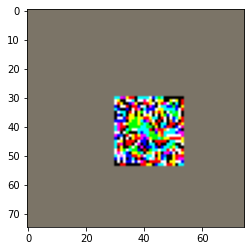


Epoch: 18000 | loss: -15641.939453
(3, 224, 224)


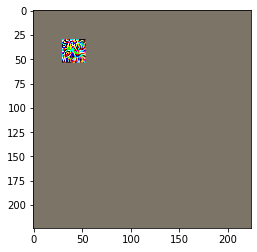

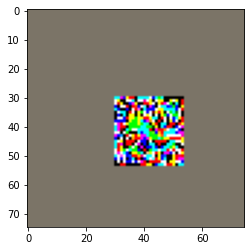

KeyboardInterrupt: ignored

In [53]:
input_image = content.clone().requires_grad_(True).to(device)
optimizer = torch.optim.AdamW([input_image], lr=learning_rate)
model.train()
for epoch in range(epochs):   
  generated_activations = get_activations(model, input_image)
  
  loss = -generated_activations[2][0, 3, 10, 10] # b c h w

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # display intermediate images and print the loss
  if epoch % 1000 == 0:
      print(f"\nEpoch: {epoch} | loss: {loss.item():.6f}")
      plt.imshow(im_convert(input_image))
      plt.show()
      plt.imshow(convert_image(input_image))
      plt.show()